In [34]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
import math
pi = math.pi

## Dataset

tensor(0)


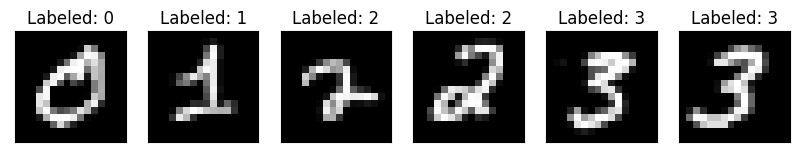

In [31]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Concentrating on the first 100 samples
n_samples = 30

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([
                            transforms.ToTensor()]),)
trans = transforms.Resize((16,16))
X_train.data = trans(X_train.data)
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
for i in range(2, 4):
    idx = np.append(idx, np.where(X_train.targets == i)[0][:n_samples])
    
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
#y_one_hot = np.zeros((len(X_train.targets), 4))
#for i in range(len(X_train.targets)):
#    y_one_hot[i, X_train.targets[i]] = 1
#X_train.targets = torch.from_numpy(y_one_hot)
#X_train.data = X_train.data[:n_samples]
#X_train.targets = X_train.targets[:n_samples]
print(X_train.targets[0])
#for i in range(2, 10):
#    idx = np.append(idx, np.where(X_train.targets == i)[0][:n_samples])
    
#X_train.data = X_train.data[idx]
#X_train.targets = X_train.targets[idx]
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)
import matplotlib.pyplot as plt
n_samples_show = 6

data_iter = iter(train_loader)

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [32]:
n_samples = 10

X_test = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([
                            transforms.ToTensor()]),)
trans = transforms.Resize((16,16))
X_test.data = trans(X_test.data)

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

for i in range(2, 4):
    idx = np.append(idx, np.where(X_test.targets == i)[0][:n_samples])
    
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]


#X_test.data = X_test.data[:n_samples]
#X_test.targets = X_test.targets[:n_samples]
print(X_test.data[0].shape)
#for i in range(2, 10):
#    idx = np.append(idx, np.where(X_test.targets == i)[0][:n_samples])
    
#X_test.data = X_test.data[idx]
#X_test.targets = X_test.targets[idx]
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

torch.Size([16, 16])


In [9]:
X_train.data = X_train.data.float()
X_test.data = X_test.data.float()

In [11]:
from qiskit.circuit import ParameterVector,Parameter
#test_theta = []
#test_phi = []
#for i in range(4):
#    test_theta.append(qiskit.circuit.Parameter(f'test_theta{i}'))
#for i in range(8):
#    test_phi.append(qiskit.circuit.Parameter(f'test_phi{i}'))
test_theta = ParameterVector('test_theta', 4)
test_phi = ParameterVector('test_phi', 8)


## Circuit Construct

In [12]:
def filter_four(phi,theta):
    qc = QuantumCircuit(4)
    for i in range (4):
        qc.ry(theta[i],i)
    qc.cry(phi[1],0,1)
    qc.cry(phi[2],1,2)
    qc.cry(phi[3],2,3)
    qc.cry(phi[0],3,0)
    return qc

test_4 = filter_four(test_phi,test_theta)
test_4.draw()

┌───────────────────┐                                      »
q_0: ┤ Ry(test_theta[0]) ├─────────■────────────────────────────»
     ├───────────────────┤┌────────┴────────┐                   »
q_1: ┤ Ry(test_theta[1]) ├┤ Ry(test_phi[1]) ├─────────■─────────»
     ├───────────────────┤└─────────────────┘┌────────┴────────┐»
q_2: ┤ Ry(test_theta[2]) ├───────────────────┤ Ry(test_phi[2]) ├»
     ├───────────────────┤                   └─────────────────┘»
q_3: ┤ Ry(test_theta[3]) ├──────────────────────────────────────»
     └───────────────────┘                                      »
«                        ┌─────────────────┐
«q_0: ───────────────────┤ Ry(test_phi[0]) ├
«                        └────────┬────────┘
«q_1: ────────────────────────────┼─────────
«                                 │         
«q_2: ─────────■──────────────────┼─────────
«     ┌────────┴────────┐         │         
«q_3: ┤ Ry(test_phi[3]) ├─────────■─────────
«     └─────────────────┘

In [13]:
# the whole structure consisting 3-qubit filter (Figure 2.(b)) is built with this function
def filter_three_layer(phi,theta):
    qc = QuantumCircuit(8)
    for i in range (8):
        qc.ry(theta[i%3],i)
    qc.cry(phi[1],0,1)
    qc.cry(phi[2],1,2)
    qc.cry(phi[3],2,3)
    qc.cry(phi[0],3,0)

    qc.cry(phi[1],4,5)
    qc.cry(phi[2],5,6)
    qc.cry(phi[3],6,7)
    qc.cry(phi[0],7,0)
    for i in range (8):
        qc.ry(phi[(i+1)%3],i)
    qc.cry(phi[1],2,3)
    qc.cry(phi[2],3,4)
    qc.cry(phi[3],4,5)
    qc.cry(phi[0],5,2)

    qc.cry(phi[1],6,7)
    qc.cry(phi[2],7,0)
    qc.cry(phi[3],0,1)
    qc.cry(phi[0],1,6)
    return qc

#test_3 = filter_three_layer(correct_phi,correct_theta)
#test_3.draw()
#test_3 = filter_three_layer(test_phi,test_theta)
#test_3.draw()

In [14]:
def filter_two(theta):
    qc = QuantumCircuit(2)
    qc.ry(theta[0],0)
    qc.ry(theta[1],1)
    qc.cx(0,1)
    qc.ry(theta[2],0)
    qc.ry(theta[3],1)
    qc.cx(1,0)
    return qc
test_2 = filter_two(test_theta)
test_2.draw()

┌───────────────────┐     ┌───────────────────┐┌───┐
q_0: ┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├
     ├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘
q_1: ┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■──
     └───────────────────┘└───┘└───────────────────┘

In [15]:
def pooling(theta):
    qc = QuantumCircuit(2)
    qc.crz(theta[0],0,1)
    qc.x(0)
    qc.crx(theta[1],0,1)
    qc.x(0)
    return qc

In [16]:
def regular_layer_y(phi,theta):
    qc = QuantumCircuit(4)
    for i in range (4):
        qc.ry(theta[i],i)
    qc.cry(phi[1],0,1)
    qc.cry(phi[2],1,2)
    qc.cry(phi[4],2,3)
    qc.cry(phi[0],3,0)

    qc.cry(phi[4],1,2)
    qc.cry(phi[5],2,3)
    qc.cry(phi[6],3,0)
    qc.cry(phi[7],0,1)
    return qc

def regular_layer_x(phi,theta):
    qc = QuantumCircuit(4)
    for i in range (4):
        qc.rx(theta[i],i)
    qc.crx(phi[1],0,1)
    qc.crx(phi[2],1,2)
    qc.crx(phi[4],2,3)
    qc.crx(phi[0],3,0)

    qc.crx(phi[4],1,2)
    qc.crx(phi[5],2,3)
    qc.crx(phi[6],3,0)
    qc.crx(phi[7],0,1)
    return qc

def regular_layer_z(phi,theta):
    qc = QuantumCircuit(4)
    for i in range (4):
        qc.rz(theta[i],i)
    qc.crz(phi[1],0,1)
    qc.crz(phi[2],1,2)
    qc.crz(phi[4],2,3)
    qc.crz(phi[0],3,0)

    qc.crz(phi[4],1,2)
    qc.crz(phi[5],2,3)
    qc.crz(phi[6],3,0)
    qc.crz(phi[7],0,1)
    return qc

In [17]:
pre_scan = QuantumCircuit(14,4)
ff = filter_four(test_phi,test_theta)
ft = filter_two(test_theta)
fth = filter_three_layer(test_phi,test_theta)
pre_scan = pre_scan.compose(ff,[1,2,3,4])
pre_scan = pre_scan.compose(ff,[5,6,7,8])
pre_scan = pre_scan.compose(ft,[1,2])
pre_scan = pre_scan.compose(ff,[3,4,5,6])
pre_scan = pre_scan.compose(ft,[7,8])
pre_scan = pre_scan.compose(fth,[1,2,3,4,5,6,7,8])
pre_scan = pre_scan.compose(ft,[1,2])
pre_scan = pre_scan.compose(ft,[3,4])
pre_scan = pre_scan.compose(ft,[5,6])
pre_scan = pre_scan.compose(ft,[7,8])
pre_scan = pre_scan.compose(ft,[0,1])
pre_scan = pre_scan.compose(ft,[2,3])
pre_scan = pre_scan.compose(ft,[4,5])
pre_scan = pre_scan.compose(ft,[6,7])
pre_scan = pre_scan.compose(ft,[8,9])

pre_scan.draw(scale = 0.5,fold=-1)

┌───────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌───────────────────┐┌───┐
 q_0: ┤ Ry(test_theta[0]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ Ry(test_theta[2]) ├┤ X ├
      ├───────────────────┤                                                           ┌─────────────────┐┌───────────────────┐                   ┌───────────────────┐        ┌───┐        ┌───────────────────┐                                                           ┌─────────────────┐                   ┌─────────────────┐┌─────────────────┐                                        ┌─────────────────┐                     ┌───────────────────┐                                                             ┌───────────────────┐        ┌───┐        ┌───────────────────┐        ┌─┴─┐        ├───────────────────┤└─┬─┘
 q_1: ┤ Ry(test_theta[0]) ├─────────■─────────────────────────────────────────────────┤ Ry(test_phi[0]) ├┤ Ry(test_theta[0]) ├─────────■─────────┤ Ry(test_theta[2]) ├────────┤ X ├────────┤ Ry(test_theta[0]) ├──────────■────────────────────────────────────────────────┤ Ry(test_phi[0]) ├───────────────────┤ Ry(test_phi[0]) ├┤ Ry(test_phi[1]) ├────────────────────────────────────────┤ Ry(test_phi[2]) ├──────────■──────────┤ Ry(test_theta[0]) ├──────────────────────────────────────────────────■──────────┤ Ry(test_theta[2]) ├────────┤ X ├────────┤ Ry(test_theta[1]) ├────────┤ X ├────────┤ Ry(test_theta[3]) ├──■──
      ├───────────────────┤┌────────┴────────┐                   ┌───────────────────┐└────────┬────────┘└───────────────────┘       ┌─┴─┐       ├───────────────────┤        └─┬─┘        ├───────────────────┤ ┌────────┴────────┐                    ┌─────────────────┐└────────┬────────┘                   └────────┬────────┘└─────────────────┘                                        └────────┬────────┘ ┌────────┴────────┐ └───────────────────┘                   ┌───────────────────┐        ┌─┴─┐        ├───────────────────┤        └─┬─┘        ├───────────────────┤        └───┘        ├───────────────────┤┌───┐
 q_2: ┤ Ry(test_theta[1]) ├┤ Ry(test_phi[1]) ├─────────■─────────┤ Ry(test_theta[1]) ├─────────┼─────────────────────────────────────┤ X ├───────┤ Ry(test_theta[3]) ├──────────■──────────┤ Ry(test_theta[1]) ├─┤ Ry(test_phi[1]) ├──────────■─────────┤ Ry(test_phi[2]) ├─────────┼─────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────┼──────────┤ Ry(test_phi[3]) ├───────────────────────────────■─────────┤ Ry(test_theta[1]) ├────────┤ X ├────────┤ Ry(test_theta[3]) ├──────────■──────────┤ Ry(test_theta[0]) ├──────────■──────────┤ Ry(test_theta[2]) ├┤ X ├
      ├───────────────────┤└─────────────────┘┌────────┴────────┐└───────────────────┘         │         ┌───────────────────┐       └───┘       └───────────────────┘                     └┬─────────────────┬┘┌┴─────────────────┴┐┌────────┴────────┐└─────────────────┘         │         ┌─────────────────┐     

In [18]:
qcnn_layer = QuantumCircuit(14)
qcnn_layer = qcnn_layer.compose(ft,[1,2])
qcnn_layer = qcnn_layer.compose(ft,[3,4])
qcnn_layer = qcnn_layer.compose(ft,[5,6])
qcnn_layer = qcnn_layer.compose(ft,[7,8])
qcnn_layer = qcnn_layer.compose(ft,[0,1])
qcnn_layer = qcnn_layer.compose(ft,[2,3])
qcnn_layer = qcnn_layer.compose(ft,[4,5])
qcnn_layer = qcnn_layer.compose(ft,[6,7])
qcnn_layer = qcnn_layer.compose(ft,[8,9])
pool = pooling(test_theta)
qcnn_layer = qcnn_layer.compose(pool,[1,2])
qcnn_layer = qcnn_layer.compose(pool,[3,4])
qcnn_layer = qcnn_layer.compose(pool,[5,6])
qcnn_layer = qcnn_layer.compose(pool,[7,8])

qcnn_layer.draw(scale=0.5,fold=-1)

┌───────────────────┐                                                         ┌───────────────────┐┌───┐                                                    
 q_0: ┤ Ry(test_theta[0]) ├──────────────────────────────────────────────────────■──┤ Ry(test_theta[2]) ├┤ X ├────────────────────────────────────────────────────
      ├───────────────────┤     ┌───────────────────┐┌───┐┌───────────────────┐┌─┴─┐├───────────────────┤└─┬─┘                     ┌───┐                     ┌───┐
 q_1: ┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■────────────■──────────┤ X ├──────────■──────────┤ X ├
      ├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘├───────────────────┤└───┘├───────────────────┤┌───┐┌─────────┴─────────┐└───┘┌─────────┴─────────┐└───┘
 q_2: ┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■──┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Rz(test_theta[0]) ├─────┤ Rx(test_theta[1]) ├─────
      ├───────────────────┤└───┘├───────────────────┤┌───┐├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘└───────────────────┘┌───┐└───────────────────┘┌───┐
 q_3: ┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■────────────■──────────┤ X ├──────────■──────────┤ X ├
      ├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘├───────────────────┤└───┘├───────────────────┤┌───┐┌─────────┴─────────┐└───┘┌─────────┴─────────┐└───┘
 q_4: ┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■──┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Rz(test_theta[0]) ├─────┤ Rx(test_theta[1]) ├─────
      ├───────────────────┤└───┘├───────────────────┤┌───┐├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘└───────────────────┘┌───┐└───────────────────┘┌───┐
 q_5: ┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■────────────■──────────┤ X ├──────────■──────────┤ X ├
      ├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘├───────────────────┤└───┘├───────────────────┤┌───┐┌─────────┴─────────┐└───┘┌─────────┴─────────┐└───┘
 q_6: ┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■──┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Rz(test_theta[0]) ├─────┤ Rx(test_theta[1]) ├─────
      ├───────────────────┤└───┘├───────────────────┤┌───┐├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘└───────────────────┘┌───┐└───────────────────┘┌───┐
 q_7: ┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■────────────■──────────┤ X ├──────────■──────────┤ X ├
      ├───────────────────┤┌─┴─┐├───────────────────┤└─┬─┘├───────────────────┤└───┘├───────────────────┤┌───┐┌─────────┴─────────┐└───┘┌─────────┴─────────┐└───┘
 q_8: ┤ Ry(test_theta[1]) ├┤ X ├┤ Ry(test_theta[3]) ├──■──┤ Ry(test_theta[0]) ├──■──┤ Ry(test_theta[2]) ├┤ X ├┤ Rz(test_theta[0]) ├─────┤ Rx(test_theta[1]) ├─────
      ├───────────────────┤└───┘└───────────────────┘     └───────────────────┘┌─┴─┐├───────────────────┤└─┬─┘└───────────────────┘     └───────────────────┘     
 q_9: ┤ Ry(test_theta[1]) ├────────────────────────────────────────────────────┤ X ├┤ Ry(test_theta[3]) ├──■──────────────────────────────────────────────────────
      └───────────────────┘                                                    └───┘└───────────────────┘                                                         
q_10: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                  
q_11: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                              

In [19]:
rly = regular_layer_y(test_phi,test_theta)
rlx = regular_layer_x(test_phi,test_theta)
rlz = regular_layer_z(test_phi,test_theta)
reg_layer = QuantumCircuit(4)
reg_layer = reg_layer.compose(rly)
reg_layer = reg_layer.compose(rly)
reg_layer = reg_layer.compose(rly)
reg_layer = reg_layer.compose(rlx)
reg_layer = reg_layer.compose(rlx)
reg_layer = reg_layer.compose(rlx)
reg_layer = reg_layer.compose(rlz)
reg_layer = reg_layer.compose(rlz)
reg_layer = reg_layer.compose(rlz)
reg_layer = reg_layer.compose(pool,[0,1])
reg_layer = reg_layer.compose(pool,[2,3])
reg_layer = reg_layer.compose(ft,[1,3])

reg_layer.draw(scale=0.5,fold=-1)

┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                     ┌───────────────────┐                                                         ┌─────────────────┐                                      ┌─────────────────┐                                                  ┌───┐                                     ┌───┐                                       
q_0: ┤ Ry(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Ry(test_phi[0]) ├──────────────────────────────────────┤ Ry(test_phi[6]) ├──────────■──────────┤ Ry(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Ry(test_phi[0]) ├──────────────────────────────────────┤ Ry(test_phi[6]) ├──────────■──────────┤ Ry(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Ry(test_phi[0]) ├──────────────────────────────────────┤ Ry(test_phi[6]) ├──────────■──────────┤ Rx(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rx(test_phi[0]) ├──────────────────────────────────────┤ Rx(test_phi[6]) ├──────────■──────────┤ Rx(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rx(test_phi[0]) ├──────────────────────────────────────┤ Rx(test_phi[6]) ├──────────■──────────┤ Rx(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rx(test_phi[0]) ├──────────────────────────────────────┤ Rx(test_phi[6]) ├──────────■──────────┤ Rz(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rz(test_phi[0]) ├──────────────────────────────────────┤ Rz(test_phi[6]) ├──────────■──────────┤ Rz(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rz(test_phi[0]) ├──────────────────────────────────────┤ Rz(test_phi[6]) ├──────────■──────────┤ Rz(test_theta[0]) ├─────────■───────────────────────────────────────────────┤ Rz(test_phi[0]) ├──────────────────────────────────────┤ Rz(test_phi[6]) ├──────────■────────────────────■──────────────────┤ X ├──────────────────■──────────────────┤ X ├───────────────────────────────────────
     ├───────────────────┤┌────────┴────────┐                                      └────────┬────────┘                                      └────────┬────────┘ ┌────────┴────────┐ ├───────────────────┤┌────────┴────────┐                                      └────────┬────────┘                                      └────────┬────────┘ ┌────────┴────────┐ ├───────────────────┤┌────────┴────────┐                                      └────────┬────────┘                                      └────────┬────────┘ ┌────────┴────────┐ ├───────────────────┤┌────────┴────────┐                                      └────

In [20]:
tof_cr = QuantumCircuit(6)
tof_cr.ccx(0,1,2)
tof_cr.x(0)
tof_cr.ccx(0,1,3)
tof_cr.x([0,1])
tof_cr.ccx(0,1,4)
tof_cr.x(0)
tof_cr.ccx(0,1,5)

tof_cr.draw(scale=0.5,fold = -1)

┌───┐     ┌───┐     ┌───┐     
q_0: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
       │  └───┘  │  ├───┤  │  └───┘  │  
q_1: ──■─────────■──┤ X ├──■─────────■──
     ┌─┴─┐       │  └───┘  │         │  
q_2: ┤ X ├───────┼─────────┼─────────┼──
     └───┘     ┌─┴─┐       │         │  
q_3: ──────────┤ X ├───────┼─────────┼──
               └───┘     ┌─┴─┐       │  
q_4: ────────────────────┤ X ├───────┼──
                         └───┘     ┌─┴─┐
q_5: ──────────────────────────────┤ X ├
                                   └───┘

## Amplutude Encoding

In [21]:
from torch.nn import functional
def amplitude_encoding(image_tensor):
    #print(image_tensor)
    image_tensor = torch.flatten(image_tensor)
    #print(image_tensor)
    image_tensor = functional.normalize(image_tensor, p=2.0, dim=0, eps=0, out=None)
    #print("im",image_tensor)
    encoding_ckt = QuantumCircuit(14,4)
    temp_reg = np.zeros(256)
    for i in range(256):
        if(i == 255 and np.sum(temp_reg**2) < 1):

            #print("ppp",np.sum(temp_reg**2))
            temp_reg[-1] = np.sqrt((1 - np.sum(temp_reg**2)))
        elif(i == 255 and np.sum(temp_reg**2) > 1):
            j = -2
            while(True):
                if(temp_reg[j]!=0):
                    break
                j-=1
            temp_sum = np.sum(temp_reg**2) - np.square(temp_reg[j])
            #print("t_sum",temp_sum)
            temp_reg[j]  = np.sqrt((1 - temp_sum))
            #print("ppp",np.sum(temp_reg**2))
        else:
            temp_reg[i] = image_tensor[i]
    #print(np.sum(temp_reg))
    #print(np.sum(temp_reg**2))
    #if(np.sum(temp_reg**2) < 1):
        #print("s",1 - np.sum(temp_reg**2))
        #temp_reg[-1] = np.sqrt((1 - np.sum(temp_reg**2)))
    encoding_ckt.initialize(temp_reg,encoding_ckt.qubits[1:9])
    return encoding_ckt

t_ac = amplitude_encoding(X_train.data[0])
t_ac.draw()
#real_ac = amplitude_encoding(X_train.data[0])
#real_ac.draw()

»
 q_0: »
      »
 q_1: »
      »
 q_2: »
      »
 q_3: »
      »
 q_4: »
      »
 q_5: »
      »
 q_6: »
      »
 q_7: »
      »
 q_8: »
      »
 q_9: »
      »
q_10: »
      »
q_11: »
      »
q_12: »
      »
q_13: »
      »
 c: 4/»
      »
«                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
« q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
«      ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
« q_1: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [17]:
for i in range(len(X_train.data)):
    t_ac = amplitude_encoding(X_train.data[i])
    #t_ac.draw() 

In [22]:
#qc:whole structure
real_ckt = pre_scan + qcnn_layer
real_ckt = real_ckt.compose(reg_layer,[2,4,6,8])
real_ckt = real_ckt.compose(tof_cr,[4,8,10,11,12,13])

real_ckt.measure([10,11,12,13],[0,1,2,3])
#real_ckt = t_ac.compose(real_ckt)
real_ckt.draw(scale = 0.2,fold = -1)
#qc.parameters.add(test_phi)
#qc.parameters.add(test_theta)

/var/folders/q3/rbp1fpy10c3ff9w1fyr_djbr0000gn/T/ipykernel_13905/720951691.py:2: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  real_ckt = pre_scan + qcnn_layer


┌───────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌───────────────────┐        ┌───┐        ┌───────────────────┐                                                         ┌───────────────────┐┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
 q_0: ┤ Ry(test_theta[0]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ Ry(test_theta[2]) ├────────┤ X ├────────┤ Ry(test_theta[0]) ├──────────────────────────────────────────────────────■──┤ Ry(test_theta[2]) ├┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [17]:
#test_theta = [(pi/8*i)for i in range(1,5)]
#test_phi = [(pi/9*(2*i-1))for i in range(1,9)]
#real_ckt.bind_parameters({test_phi: [(pi/9*(2*i-1))for i in range(1,9)]})
#real_ckt.bind_parameters({test_theta: [(pi/8*i)for i in range(1,5)]})
#real_ckt.parameters

## run Circuit

In [26]:
from qiskit import transpile,assemble
class My_QuantumCircuit:
    def __init__(self,image,circuit,backend,shots):
        ac = amplitude_encoding(image)
        self.circuit = circuit
        #print(self.circuit.parameters)
        #self.circuit.draw()
        self.circuit = ac.compose(self.circuit)
        self.backend = backend
        self.shots = shots
        #self.circuit.draw()
        
    def run(self,thetas,phis):
        #self.circuit.assign_parameters({
        #'test_phi0':phis[0],'test_phi1':phis[1],'test_phi2':phis[2],'test_phi3':phis[3],'test_phi4':phis[4],'test_phi5':phis[5],'test_phi6':phis[7],'test_phi7':phis[7]
        #,'test_theta0':thetas[0],'test_theta1':thetas[1],'test_theta2':thetas[2],'test_theta3':thetas[3]})
        self.circuit = self.circuit.assign_parameters({test_theta:thetas,test_phi:phis})
        #print("llll",type(thetas),len(thetas))
        #print("qqq",thetas,phis)
        #self.circuit.draw()
        #job = qiskit.execute(self.circuit,
        #                 self.backend,
        #                 shots = self.shots,
        #                 parameter_binds = [{test_theta :thetas,
        #               test_phi:phis}])
        
        job = qiskit.execute(self.circuit,
                         self.backend,
                         shots = self.shots,
                         )
        #t_qc = transpile(self.circuit,self.backend)
        #q_obj = assemble(t_qc,shots = self.shots)
        #job = self.backend.run(q_obj)
        result = job.result().get_counts()
        #print("sk",result)
        collection = [0] * 4
        #It means the probability of '1' for each qubit
        for str_ in list(result.keys()):
            for j in range(len(str_)):
                if int(str_[len(str_) - 1 - j]):
                    collection[j] += 1/self.shots * result[str_]
        
        #print('collection = ', collection)
        collection = torch.FloatTensor(collection)
        return collection  
        
'''
job = qiskit.execute(self.circuit,
                         self.backend,
                         shots = self.shots,
                         parameter_binds = [{test_theta[0]: thetas[0],
                         test_theta[1]: thetas[1],
                         test_theta[2]: thetas[2],
                         test_theta[3]: thetas[3],
                                            test_phi[0]: phis[0],
                                             test_phi[1]: phis[1],
                                             test_phi[2]: phis[2],
                                             test_phi[3]: phis[3],
                                             test_phi[4]: phis[4],
                                             test_phi[5]: phis[5],
                                             test_phi[6]: phis[6],
                                             test_phi[7]: phis[7]}])
                                             '''


'\njob = qiskit.execute(self.circuit,\n                         self.backend,\n                         shots = self.shots,\n                         parameter_binds = [{test_theta[0]: thetas[0],\n                         test_theta[1]: thetas[1],\n                         test_theta[2]: thetas[2],\n                         test_theta[3]: thetas[3],\n                                            test_phi[0]: phis[0],\n                                             test_phi[1]: phis[1],\n                                             test_phi[2]: phis[2],\n                                             test_phi[3]: phis[3],\n                                             test_phi[4]: phis[4],\n                                             test_phi[5]: phis[5],\n                                             test_phi[6]: phis[6],\n                                             test_phi[7]: phis[7]}])\n                                             '

## Hybrid Function

In [19]:
thetas,phis = [],[]
from torch.autograd import Function
class trainingFunction(Function):
    
    @staticmethod
    def forward(self,thetas,phis,qc,shift):
        self.shift = shift
        self.qc = qc
        
        #print("input",input[0].shape)
        #expectation_z = self.qc.run(input[0].tolist())
        expectation_z = self.qc.run(thetas,phis)
        result = torch.tensor([expectation_z])
        self.save_for_backward(thetas,phis,result)
        print("result",result)
        return result,thetas,phis
    
    @staticmethod
    def backward(self,grad_output):
        """ Backward pass computation """
        thetas,phis, expectation_z = self.saved_tensors
        
        
        theta_list = np.array(thetas)
        phi_list = np.array(phis)

        shift_right_t = theta_list + np.ones(theta_list.shape) * self.shift
        shift_left_t = theta_list - np.ones(theta_list.shape) * self.shift
        shift_left_p = phi_list - np.ones(phi_list.shape) * self.shift
        shift_right_p = phi_list + np.ones(phi_list.shape) * self.shift
        shift_left = np.concatenate(shift_left_t,shift_left_p)
        shift_right = np.concatenate(shift_right_t,shift_right_p)

        #gradients = []
        
        for i in range(len(shift_left)):
            expectation_right = self.quantum_circuit.run(shift_right[i])
            expectation_left  = self.quantum_circuit.run(shift_left[i])
            
            gradient = 0.5 * (torch.tensor([expectation_right]) - torch.tensor([expectation_left]))
    
            gradients = gradient.numpy()
            #gradients.append(gradient)
   
            
        #gradients = np.array([gradients]).T
        print("G",gradients)
        return torch.tensor(gradients).float() * grad_output.float(), None, None
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self,image,qc,shift,backend,shots):
        super(Hybrid, self).__init__()
        self.quantum_circuit = My_QuantumCircuit(image,qc,backend,shots)
        self.shift = shift
        
    def forward(self, input):
        return trainingFunction.apply(input, self.quantum_circuit, self.shift)

## Net initialize

In [20]:
class Net(nn.Module):
    def __init__(self,image):
        super(Net,self).__init__()
        self.hybrid = Hybrid(image,real_ckt,pi/2,qiskit.Aer.get_backend('aer_simulator'),1000)
    def forward(self,x):
        x,thetas,phis = self.hybrid(x)
        x = F.softmax(x)
        return x,thetas,phis


In [36]:
import qiskit

In [37]:
#from qiskit.algorithms.optimizers import COBYLA
#model = Net()
#optimizer = optim.Adam(qc.parameters,lr=0.001)
loss_func = nn.CrossEntropyLoss()
#optimizer=COBYLA()


epochs = 1
loss_list = []
learning_rate = 0.0001
thetas = np.random.normal(0,1,4)
phis = np.random.normal(0,1,8)
for epoch in range(epochs):
    print(f'Epoch{epoch+1}')
    total_loss = []
    shift = pi/2
    for batch_idx,(data, target) in enumerate(train_loader):
        use_tar = np.zeros(4)
        #print(use_tar)
        #print("s",target[0])
        use_tar[target[0]] = 1
        use_tar = torch.tensor(use_tar)
        
        model = My_QuantumCircuit(data,real_ckt,qiskit.Aer.get_backend('aer_simulator'),1000)
        #print(model.circuit.parameters)
        ## gradient descent
        theta_list = np.array(thetas)
        phi_list = np.array(phis)
        #print(theta_list)
        param_list = np.concatenate((theta_list,phi_list),axis = None)

        for i in range(len(param_list)):
            rmodel = My_QuantumCircuit(data,real_ckt,qiskit.Aer.get_backend('aer_simulator'),1000)
            lmodel = My_QuantumCircuit(data,real_ckt,qiskit.Aer.get_backend('aer_simulator'),1000)
            shift_right = param_list[i] + shift
            shift_left = param_list[i] - shift
            temp_r = param_list
            temp_l = param_list
            temp_r[i] = shift_right
            temp_l[i] = shift_left
            temp_rt = temp_r[:4]
            #print("j",temp_rt)
            #print("jf",temp_rt[0])
            temp_rp = temp_r[4:]
            temp_lt = temp_l[:4]
            temp_lp = temp_l[4:]
            pred_right = rmodel.run(temp_rt.tolist(),temp_rp.tolist())
            pred_left  = lmodel.run(temp_lt.tolist(),temp_lp.tolist())
            loss_r = loss_func(pred_right,use_tar)
            loss_l = loss_func(pred_left,use_tar)

            gradient = 0.5 * (torch.tensor([loss_r]) - torch.tensor([loss_l]))
            gradient = gradient.numpy()
            param_list[i] = param_list[i] - learning_rate * gradient
            print("param",param_list)
        thetas = param_list[:4]
        phis = param_list[4:]
    pred = model.run(thetas,phis)
    loss = loss_func(pred,target)
    total_loss.append(loss)
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss))
        

        


'''
shift_right_t = theta_list + np.ones(theta_list.shape) * shift
        shift_left_t = theta_list - np.ones(theta_list.shape) * shift
        shift_left_p = phi_list - np.ones(phi_list.shape) * shift
        shift_right_p = phi_list + np.ones(phi_list.shape) * shift
        shift_left = np.concatenate(shift_left_t,shift_left_p)
        shift_right = np.concatenate(shift_right_t,shift_right_p)
        
        #gradients = []
        
        for i in range(len(shift_left)):
            expectation_right = model.run(shift_right[i])
            expectation_left  = model.run(shift_left[i])
            
            gradient = 0.5 * (torch.tensor([expectation_right]) - torch.tensor([expectation_left]))
    
            gradients = gradient.numpy()
#model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx,(data, target) in enumerate(train_loader):
        model = Net(data)
        model.train()
        #optimizer.zero_grad()
        #Forward pass
        #print(data.size())
        output = model(data)
        print()
        # Calculating loss
        #print('output = ', output)
        #print('target = ', target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        #optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))
'''

Epoch1
opop test_theta, ['test_theta[0]', 'test_theta[1]', 'test_theta[2]', 'test_theta[3]']
opop test_phi, ['test_phi[0]', 'test_phi[1]', 'test_phi[2]', 'test_phi[3]', 'test_phi[4]', 'test_phi[5]', 'test_phi[6]', 'test_phi[7]']
opop test_theta, ['test_theta[0]', 'test_theta[1]', 'test_theta[2]', 'test_theta[3]']
opop test_phi, ['test_phi[0]', 'test_phi[1]', 'test_phi[2]', 'test_phi[3]', 'test_phi[4]', 'test_phi[5]', 'test_phi[6]', 'test_phi[7]']
param [ 0.81596273 -1.76128258 -0.97266317  1.36012166 -0.59894968  1.06302625
  1.10868392 -0.21460672  0.17914666  0.41277215 -1.82249602  1.88041297]
opop test_theta, ['test_theta[0]', 'test_theta[1]', 'test_theta[2]', 'test_theta[3]']
opop test_phi, ['test_phi[0]', 'test_phi[1]', 'test_phi[2]', 'test_phi[3]', 'test_phi[4]', 'test_phi[5]', 'test_phi[6]', 'test_phi[7]']
opop test_theta, ['test_theta[0]', 'test_theta[1]', 'test_theta[2]', 'test_theta[3]']
opop test_phi, ['test_phi[0]', 'test_phi[1]', 'test_phi[2]', 'test_phi[3]', 'test_phi[4]

KeyboardInterrupt: 

In [32]:
a = np.array([1.1,2,3])
a

array([1.1, 2. , 3. ])

In [33]:
a[0]

1.1